In [1]:
def find_planet_signature(data_path, system_num):
    
    import numpy as np
    import matplotlib.pyplot as plt

    from astropy.timeseries import LombScargle
    from astropy.io import ascii
    from scipy.optimize import curve_fit
    
    pass_num = 1
    ordinal_numbers = {'1':'First', '2':'Second', '3': 'Third', '4':'Fourth', '5':'Fifth'}
    
    # Read in the data, remove Julian timing
    system = ascii.read(data_path)
    system['date'] = system['date'] - system['date'][0]
    
    choice = 'y'
    while choice == 'y':
        
        system_name = 'System ' + str(system_num) + ', ' + ordinal_numbers[str(pass_num)] + ' Pass'
        save_fig_name = 'sys_' + str(system_num) + '_pass_' + str(pass_num)
        save_fig_path = 'sys_' + str(system_num) + '/'
    
        # Plot the data
        plt.errorbar(system['date'], system['vel'], system['unc'], fmt='.k', ecolor='grey')
        plt.xlabel('Time (days)')
        plt.ylabel('Radial Velocity ($m/s$)')
        plt.title(system_name)
        plt.savefig(save_fig_path + save_fig_name + '.pdf')
        plt.show()

        # Compute the Lomb-Scargle periodogram of the data and plot
        ls = LombScargle(system['date'], system['vel'], system['unc'])
        freq, power = ls.autopower(nyquist_factor=50)
        plt.clf()
        plt.plot(freq, power)
        plt.xlabel('Frequency')
        plt.ylabel('Lomb-Scargle Power')
        plt.title(system_name)
        plt.savefig(save_fig_path + save_fig_name + '_ls.pdf')
        plt.show()

        # Determine the false alarm probability of the periodogram maximum
        false_alarm_prob = ls.false_alarm_probability(power.max(), method='bootstrap')
        print('Under the assumption that there is no periodic signal in the data, we will observe a peak at {:.2f} or above approximately {:.2f}% of the time.'.format(power.max(), false_alarm_prob*100))

        # Compute the best fit sinusoid
        plt.clf()
        period_days = 1 / freq
        best_period = period_days[np.argmax(power)]
        phase = (system['date'] / best_period) % 1
        plt.errorbar(phase, system['vel'], system['unc'], label='Phased Data', fmt='.k', ecolor='grey')

        phase_model = np.linspace(0, 1)
        best_frequency = freq[np.argmax(power)]
        vel_model = ls.model(phase_model / best_frequency, best_frequency)
        plt.plot(phase_model, vel_model, label='Model')

        plt.xlabel('Phase')
        plt.ylabel('Radial Velocity ($m/s$)')
        plt.title(system_name)
        plt.legend()
        plt.savefig(save_fig_path + save_fig_name + '_phase_plot.pdf')
        plt.show()

        def fit_sin(tt, yy):
            '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
            tt = np.array(tt)
            yy = np.array(yy)
            ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
            Fyy = abs(np.fft.fft(yy))
            guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
            guess_amp = np.std(yy) * 2.**0.5
            guess_offset = np.mean(yy)
            guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

            def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
            popt, pcov = curve_fit(sinfunc, tt, yy, p0=guess)
            A, w, p, c = popt
            f = w/(2.*np.pi)
            fitfunc = lambda t: A * np.sin(w*t + p) + c
            return fitfunc, A

        fit, A = fit_sin(phase, system['vel'])
        system['vel'] = system['vel'] - fit(phase.value)
        
        plt.clf()
        plt.errorbar(phase, system['vel'], system['unc'], fmt='.k', ecolor='grey')
        plt.xlabel('Phase')
        plt.ylabel('Radial Velocity Residuals ($m/s$)')
        plt.title(system_name)
        plt.savefig(save_fig_path + save_fig_name + '_residuals.pdf')
        plt.show()
        
        freq_unc = np.abs((3 * np.pi * np.sqrt(np.var(system['vel']))) / (2 * np.sqrt(len(system)) * system['date'][-1] * A))
        percent_unc = freq_unc / best_frequency
        period_unc = percent_unc * best_period
        
        print('The best period for ' + system_name + ' is {:.8f} days, plus or minus {:.8f}.'.format(best_period, period_unc))

        pass_num += 1
        
        choice = str(input('Do you want to do another pass? (y/n) '))

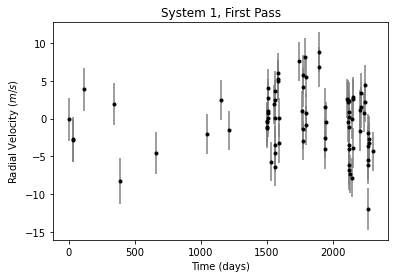

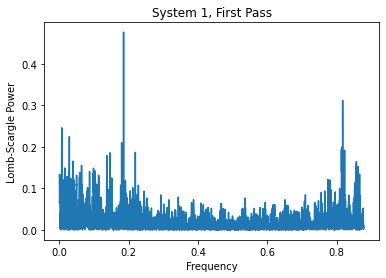

Under the assumption that there is no periodic signal in the data, we will observe a peak at 0.48 or above approximately 0.00% of the time.


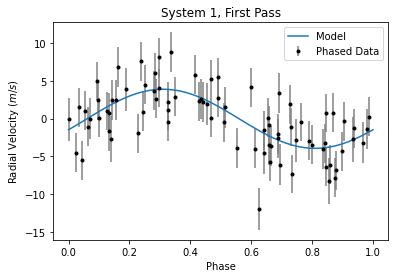

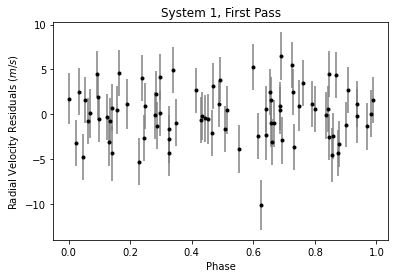

The best period for System 1, First Pass is 5.39897868 days, plus or minus 0.00492051.


Do you want to do another pass? (y/n)  n


In [2]:
data_path = 'system_1.txt'
system_num = 1
find_planet_signature(data_path, system_num)

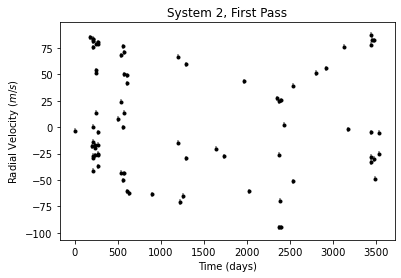

In [ ]:
data_path = 'system_2.txt'
system_num = 2
find_planet_signature(data_path, system_num)

In [ ]:
data_path = 'system_3.txt'
system_num = 3
find_planet_signature(data_path, system_num)